In [1]:
import asyncio
import json
import logging
import math
import os
import re
import warnings
from abc import ABC, abstractmethod
from collections import defaultdict
from pathlib import Path
from queue import PriorityQueue
from urllib.parse import urljoin

import bottleneck as bn
import nest_asyncio
import numpy as np
import obspy
import torch
import torch.multiprocessing as torchmp
import torch.nn as nn
import torch.nn.functional as F
from obspy.signal.trigger import trigger_onset
from packaging import version

import seisbench
import seisbench.util as util
from seisbench.util import in_notebook, log_lifecycle
import seisbench.models as sbm

from scipy import signal
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from laplace.baselaplace import FullLaplace
from laplace.curvature.backpack import BackPackGGN

# Layers

In [8]:
class CustomLSTM(nn.Module):
    """
    LSTM to be used with custom cells
    """

    def __init__(self, cell, *cell_args, bidirectional=True, **cell_kwargs):
        super(CustomLSTM, self).__init__()
        self.cell_f = cell(*cell_args, **cell_kwargs)
        self.bidirectional = bidirectional
        if self.bidirectional:
            self.cell_b = cell(*cell_args, **cell_kwargs)

    def forward(self, input, state=None):
        # Forward
        state_f = state
        outputs_f = []
        for i in range(len(input)):
            out, state_f = self.cell_f(input[i], state_f)
            outputs_f += [out]

        outputs_f = torch.stack(outputs_f)

        if not self.bidirectional:
            return outputs_f, None

        # Backward
        state_b = state
        outputs_b = []
        l = input.shape[0] - 1
        for i in range(len(input)):
            out, state_b = self.cell_b(input[l - i], state_b)
            outputs_b += [out]

        outputs_b = torch.flip(torch.stack(outputs_b), dims=[0])

        output = torch.cat([outputs_f, outputs_b], dim=-1)

        # Keep second argument for consistency with PyTorch LSTM
        return output, None

In [9]:
def hard_sigmoid(x):
    return torch.clip(0.2 * x + 0.5, 0, 1)

class ActivationLSTMCell(nn.Module):
    """
    LSTM Cell using variable gating activation, by default hard sigmoid

    If gate_activation=torch.sigmoid this is the standard LSTM cell

    Uses recurrent dropout strategy from https://arxiv.org/abs/1603.05118 to match Keras implementation.
    """

    def __init__(
        self, input_size, hidden_size, gate_activation=hard_sigmoid, recurrent_dropout=0
    ):
        super(ActivationLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gate_activation = gate_activation
        self.recurrent_dropout = recurrent_dropout

        self.weight_ih = nn.Parameter(torch.randn(4 * hidden_size, input_size))
        self.weight_hh = nn.Parameter(torch.randn(4 * hidden_size, hidden_size))
        self.bias_ih = nn.Parameter(torch.randn(4 * hidden_size))
        self.bias_hh = nn.Parameter(torch.randn(4 * hidden_size))
        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            for param in [self.weight_hh, self.weight_ih]:
                for idx in range(4):
                    mul = param.shape[0] // 4
                    torch.nn.init.xavier_uniform_(param[idx * mul : (idx + 1) * mul])

    def forward(self, input, state):
        if state is None:
            hx = torch.zeros(
                input.shape[0], self.hidden_size, device=input.device, dtype=input.dtype
            )
            cx = torch.zeros(
                input.shape[0], self.hidden_size, device=input.device, dtype=input.dtype
            )
        else:
            hx, cx = state
        gates = (
            torch.mm(input, self.weight_ih.t())
            + self.bias_ih
            + torch.mm(hx, self.weight_hh.t())
            + self.bias_hh
        )
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)

        ingate = self.gate_activation(ingate)
        forgetgate = self.gate_activation(forgetgate)
        cellgate = torch.tanh(cellgate)
        outgate = self.gate_activation(outgate)

        if self.recurrent_dropout > 0:
            cellgate = F.dropout(cellgate, p=self.recurrent_dropout)

        cy = (forgetgate * cx) + (ingate * cellgate)
        hy = outgate * torch.tanh(cy)

        return hy, (hy, cy)

In [10]:
class EQTransformer(nn.Module):
    """
    The EQTransformer from Mousavi et al. (2020)

    Implementation adapted from the Github repository https://github.com/smousavi05/EQTransformer
    Assumes padding="same" and activation="relu" as in the pretrained EQTransformer models

    By instantiating the model with `from_pretrained("original")` a binary compatible version of the original
    EQTransformer with the original weights from Mousavi et al. (2020) can be loaded.

    .. document_args:: seisbench.models EQTransformer

    :param in_channels: Number of input channels, by default 3.
    :param in_samples: Number of input samples per channel, by default 6000.
                       The model expects input shape (in_channels, in_samples)
    :param classes: Number of output classes, by default 2. The detection channel is not counted.
    :param phases: Phase hints for the classes, by default "PS". Can be None.
    :param res_cnn_blocks: Number of residual convolutional blocks
    :param lstm_blocks: Number of LSTM blocks
    :param drop_rate: Dropout rate
    :param original_compatible: If True, uses a few custom layers for binary compatibility with original model
                                from Mousavi et al. (2020).
                                This option defaults to False.
                                It is usually recommended to stick to the default value, as the custom layers show
                                slightly worse performance than the PyTorch builtins.
                                The exception is when loading the original weights using :py:func:`from_pretrained`.
    :param norm: Data normalization strategy, either "peak" or "std".
    :param kwargs: Keyword arguments passed to the constructor of :py:class:`WaveformModel`.
    """

    def __init__(
        self,
        in_channels=3,
        in_samples=6000,
        classes=2,
        phases="PS",
        lstm_blocks=3,
        drop_rate=0.1,
        original_compatible=False,
        sampling_rate=100,
        norm="std",
        **kwargs,
    ):
        super().__init__()
        self.in_samples = in_samples
        self.in_channels = in_channels
        self.classes = classes
        self.lstm_blocks = lstm_blocks
        self.drop_rate = drop_rate
        self.norm = norm

        # Add options for conservative and the true original - see https://github.com/seisbench/seisbench/issues/96#issuecomment-1155158224
        if original_compatible == True:
            warnings.warn(
                "Using the non-conservative 'original' model, set `original_compatible='conservative' to use the more conservative model"
            )
            original_compatible = "non-conservative"

        if original_compatible:
            eps = 1e-7  # See Issue #96 - original models use tensorflow default epsilon of 1e-7
        else:
            eps = 1e-5
        self.original_compatible = original_compatible

        if original_compatible and in_samples != 6000:
            raise ValueError("original_compatible=True requires in_samples=6000.")

        self._phases = phases
        if phases is not None and len(phases) != classes:
            raise ValueError(
                f"Number of classes ({classes}) does not match number of phases ({len(phases)})."
            )

        # Parameters from EQTransformer repository
        self.filters = [
            8,
            16,
            16,
            32,
            32,
            64,
            64,
        ]  # Number of filters for the convolutions
        self.kernel_sizes = [11, 9, 7, 7, 5, 5, 3]  # Kernel sizes for the convolutions
        self.res_cnn_kernels = [3, 3, 3, 3, 2, 3, 2]

        # TODO: Add regularizers when training model
        # kernel_regularizer=keras.regularizers.l2(1e-6),
        # bias_regularizer=keras.regularizers.l1(1e-4),

        # Encoder stack
        self.encoder = Encoder(
            input_channels=self.in_channels,
            filters=self.filters,
            kernel_sizes=self.kernel_sizes,
            in_samples=self.in_samples,
        )

        # Res CNN Stack
        self.res_cnn_stack = ResCNNStack(
            kernel_sizes=self.res_cnn_kernels,
            filters=self.filters[-1],
            drop_rate=self.drop_rate,
        )

        # BiLSTM stack
        self.bi_lstm_stack = BiLSTMStack(
            blocks=self.lstm_blocks,
            input_size=self.filters[-1],
            drop_rate=self.drop_rate,
            original_compatible=original_compatible,
        )

        # Global attention - two transformers
        self.transformer_d0 = Transformer(
            input_size=16, drop_rate=self.drop_rate, eps=eps
        )
        self.transformer_d = Transformer(
            input_size=16, drop_rate=self.drop_rate, eps=eps
        )

        # Detection decoder and final Conv
        self.decoder_d = Decoder(
            input_channels=16,
            filters=self.filters[::-1],
            kernel_sizes=self.kernel_sizes[::-1],
            out_samples=in_samples,
            original_compatible=original_compatible,
        )
        self.conv_d = nn.Conv1d(
            in_channels=self.filters[0], out_channels=1, kernel_size=11, padding=5
        )

        # Picking branches
        self.pick_lstms = []
        self.pick_attentions = []
        self.pick_decoders = []
        self.pick_convs = []
        self.dropout = nn.Dropout(drop_rate)

        for _ in range(self.classes):
            if original_compatible == "conservative":
                # The non-conservative model uses a sigmoid activiation as handled by the base nn.LSTM
                lstm = CustomLSTM(ActivationLSTMCell, 16, 16, bidirectional=False)
            else:
                lstm = nn.LSTM(16, 16, bidirectional=False)
            self.pick_lstms.append(lstm)

            attention = SeqSelfAttention(input_size=16, attention_width=3, eps=eps)
            self.pick_attentions.append(attention)

            decoder = Decoder(
                input_channels=16,
                filters=self.filters[::-1],
                kernel_sizes=self.kernel_sizes[::-1],
                out_samples=in_samples,
                original_compatible=original_compatible,
            )
            self.pick_decoders.append(decoder)

            conv = nn.Conv1d(
                in_channels=self.filters[0], out_channels=1, kernel_size=11, padding=5
            )
            self.pick_convs.append(conv)

        self.pick_lstms = nn.ModuleList(self.pick_lstms)
        self.pick_attentions = nn.ModuleList(self.pick_attentions)
        self.pick_decoders = nn.ModuleList(self.pick_decoders)
        self.pick_convs = nn.ModuleList(self.pick_convs)

    def forward(self, x, logits=False):
        assert x.ndim == 3
        assert x.shape[1:] == (self.in_channels, self.in_samples)

        # Shared encoder part
        x = self.encoder(x)
        x = self.res_cnn_stack(x)
        x = self.bi_lstm_stack(x)
        x, _ = self.transformer_d0(x)
        x, _ = self.transformer_d(x)

        # Detection part
        detection = self.decoder_d(x)
        if logits:
            detection = self.conv_d(detection)
        else:
            detection = torch.sigmoid(self.conv_d(detection))
        detection = torch.squeeze(detection, dim=1)  # Remove channel dimension

        outputs = [detection]

        # Pick parts
        for lstm, attention, decoder, conv in zip(
            self.pick_lstms, self.pick_attentions, self.pick_decoders, self.pick_convs
        ):
            px = x.permute(
                2, 0, 1
            )  # From batch, channels, sequence to sequence, batch, channels
            px = lstm(px)[0]
            px = self.dropout(px)
            px = px.permute(
                1, 2, 0
            )  # From sequence, batch, channels to batch, channels, sequence
            px, _ = attention(px)
            px = decoder(px)
            if logits:
                pred = conv(px)
            else:
                pred = torch.sigmoid(conv(px))
            pred = torch.squeeze(pred, dim=1)  # Remove channel dimension

            outputs.append(pred)

        return tuple(outputs)

        # Cosine taper (very short, i.e., only six samples on each side)
        tap = 0.5 * (1 + np.cos(np.linspace(np.pi, 2 * np.pi, 6)))
        window[:, :6] *= tap
        window[:, -6:] *= tap[::-1]

        return window


class Encoder(nn.Module):
    """
    Encoder stack
    """

    def __init__(self, input_channels, filters, kernel_sizes, in_samples):
        super().__init__()

        convs = []
        pools = []
        self.paddings = []
        for in_channels, out_channels, kernel_size in zip(
            [input_channels] + filters[:-1], filters, kernel_sizes
        ):
            convs.append(
                nn.Conv1d(
                    in_channels, out_channels, kernel_size, padding=kernel_size // 2
                )
            )

            # To be consistent with the behaviour in tensorflow,
            # padding needs to be added for odd numbers of input_samples
            padding = in_samples % 2

            # Padding for MaxPool1d needs to be handled manually to conform with tf padding
            self.paddings.append(padding)
            pools.append(nn.MaxPool1d(2, padding=0))
            in_samples = (in_samples + padding) // 2

        self.convs = nn.ModuleList(convs)
        self.pools = nn.ModuleList(pools)

    def forward(self, x):
        for conv, pool, padding in zip(self.convs, self.pools, self.paddings):
            x = torch.relu(conv(x))
            if padding != 0:
                # Only pad right, use -1e10 as negative infinity
                x = F.pad(x, (0, padding), "constant", -1e10)
            x = pool(x)

        return x


class Decoder(nn.Module):
    def __init__(
        self,
        input_channels,
        filters,
        kernel_sizes,
        out_samples,
        original_compatible=False,
    ):
        super().__init__()

        self.upsample = nn.Upsample(scale_factor=2, mode="nearest")
        self.original_compatible = original_compatible

        # We need to trim off the final sample sometimes to get to the right number of output samples
        self.crops = []
        current_samples = out_samples
        for i, _ in enumerate(filters):
            padding = current_samples % 2
            current_samples = (current_samples + padding) // 2
            if padding == 1:
                self.crops.append(len(filters) - 1 - i)

        convs = []
        for in_channels, out_channels, kernel_size in zip(
            [input_channels] + filters[:-1], filters, kernel_sizes
        ):
            convs.append(
                nn.Conv1d(
                    in_channels, out_channels, kernel_size, padding=kernel_size // 2
                )
            )

        self.convs = nn.ModuleList(convs)

    def forward(self, x):
        for i, conv in enumerate(self.convs):
            x = self.upsample(x)

            if self.original_compatible:
                if i == 3:
                    x = x[:, :, 1:-1]
            else:
                if i in self.crops:
                    x = x[:, :, :-1]

            x = F.relu(conv(x))

        return x


class ResCNNStack(nn.Module):
    def __init__(self, kernel_sizes, filters, drop_rate):
        super().__init__()

        members = []
        for ker in kernel_sizes:
            members.append(ResCNNBlock(filters, ker, drop_rate))

        self.members = nn.ModuleList(members)

    def forward(self, x):
        for member in self.members:
            x = member(x)

        return x


class ResCNNBlock(nn.Module):
    def __init__(self, filters, ker, drop_rate):
        super().__init__()

        self.manual_padding = False
        if ker == 3:
            padding = 1
        else:
            # ker == 2
            # Manual padding emulate the padding in tensorflow
            self.manual_padding = True
            padding = 0

        self.dropout = SpatialDropout1d(drop_rate)

        self.norm1 = nn.BatchNorm1d(filters, eps=1e-3)
        self.conv1 = nn.Conv1d(filters, filters, ker, padding=padding)

        self.norm2 = nn.BatchNorm1d(filters, eps=1e-3)
        self.conv2 = nn.Conv1d(filters, filters, ker, padding=padding)

    def forward(self, x):
        y = self.norm1(x)
        y = F.relu(y)
        y = self.dropout(y)
        if self.manual_padding:
            y = F.pad(y, (0, 1), "constant", 0)
        y = self.conv1(y)

        y = self.norm2(y)
        y = F.relu(y)
        y = self.dropout(y)
        if self.manual_padding:
            y = F.pad(y, (0, 1), "constant", 0)
        y = self.conv2(y)

        return x + y


class BiLSTMStack(nn.Module):
    def __init__(
        self, blocks, input_size, drop_rate, hidden_size=16, original_compatible=False
    ):
        super().__init__()

        # First LSTM has a different input size as the subsequent ones
        self.members = nn.ModuleList(
            [
                BiLSTMBlock(
                    input_size,
                    hidden_size,
                    drop_rate,
                    original_compatible=original_compatible,
                )
            ]
            + [
                BiLSTMBlock(
                    hidden_size,
                    hidden_size,
                    drop_rate,
                    original_compatible=original_compatible,
                )
                for _ in range(blocks - 1)
            ]
        )

    def forward(self, x):
        for member in self.members:
            x = member(x)
        return x


class BiLSTMBlock(nn.Module):
    def __init__(self, input_size, hidden_size, drop_rate, original_compatible=False):
        super().__init__()

        if original_compatible == "conservative":
            # The non-conservative model uses a sigmoid activiation as handled by the base nn.LSTM
            self.lstm = CustomLSTM(ActivationLSTMCell, input_size, hidden_size)
        elif original_compatible == "non-conservative":
            self.lstm = CustomLSTM(
                ActivationLSTMCell,
                input_size,
                hidden_size,
                gate_activation=torch.sigmoid,
            )
        else:
            self.lstm = nn.LSTM(input_size, hidden_size, bidirectional=True)
        self.dropout = nn.Dropout(drop_rate)
        self.conv = nn.Conv1d(2 * hidden_size, hidden_size, 1)
        self.norm = nn.BatchNorm1d(hidden_size, eps=1e-3)

    def forward(self, x):
        x = x.permute(
            2, 0, 1
        )  # From batch, channels, sequence to sequence, batch, channels
        x = self.lstm(x)[0]
        x = self.dropout(x)
        x = x.permute(
            1, 2, 0
        )  # From sequence, batch, channels to batch, channels, sequence
        x = self.conv(x)
        x = self.norm(x)
        return x


class Transformer(nn.Module):
    def __init__(self, input_size, drop_rate, attention_width=None, eps=1e-5):
        super().__init__()

        self.attention = SeqSelfAttention(
            input_size, attention_width=attention_width, eps=eps
        )
        self.norm1 = LayerNormalization(input_size)
        self.ff = FeedForward(input_size, drop_rate)
        self.norm2 = LayerNormalization(input_size)

    def forward(self, x):
        y, weight = self.attention(x)
        y = x + y
        y = self.norm1(y)
        y2 = self.ff(y)
        y2 = y + y2
        y2 = self.norm2(y2)

        return y2, weight


class SeqSelfAttention(nn.Module):
    """
    Additive self attention
    """

    def __init__(self, input_size, units=32, attention_width=None, eps=1e-5):
        super().__init__()
        self.attention_width = attention_width

        self.Wx = nn.Parameter(uniform(-0.02, 0.02, input_size, units))
        self.Wt = nn.Parameter(uniform(-0.02, 0.02, input_size, units))
        self.bh = nn.Parameter(torch.zeros(units))

        self.Wa = nn.Parameter(uniform(-0.02, 0.02, units, 1))
        self.ba = nn.Parameter(torch.zeros(1))

        self.eps = eps

    def forward(self, x):
        # x.shape == (batch, channels, time)

        x = x.permute(0, 2, 1)  # to (batch, time, channels)

        q = torch.unsqueeze(
            torch.matmul(x, self.Wt), 2
        )  # Shape (batch, time, 1, channels)
        k = torch.unsqueeze(
            torch.matmul(x, self.Wx), 1
        )  # Shape (batch, 1, time, channels)

        h = torch.tanh(q + k + self.bh)

        # Emissions
        e = torch.squeeze(
            torch.matmul(h, self.Wa) + self.ba, -1
        )  # Shape (batch, time, time)

        # This is essentially softmax with an additional attention component.
        e = (
            e - torch.max(e, dim=-1, keepdim=True).values
        )  # In versions <= 0.2.1 e was incorrectly normalized by max(x)
        e = torch.exp(e)
        if self.attention_width is not None:
            lower = (
                torch.arange(0, e.shape[1], device=e.device) - self.attention_width // 2
            )
            upper = lower + self.attention_width
            indices = torch.unsqueeze(torch.arange(0, e.shape[1], device=e.device), 1)
            mask = torch.logical_and(lower <= indices, indices < upper)
            e = torch.where(mask, e, torch.zeros_like(e))

        a = e / (torch.sum(e, dim=-1, keepdim=True) + self.eps)

        v = torch.matmul(a, x)

        v = v.permute(0, 2, 1)  # to (batch, channels, time)

        return v, a


def uniform(a, b, *args):
    return a + (b - a) * torch.rand(*args)


class LayerNormalization(nn.Module):
    def __init__(self, filters, eps=1e-14):
        super().__init__()

        gamma = torch.ones(filters, 1)
        self.gamma = nn.Parameter(gamma)
        beta = torch.zeros(filters, 1)
        self.beta = nn.Parameter(beta)
        self.eps = eps

    def forward(self, x):
        mean = torch.mean(x, 1, keepdim=True)
        var = torch.mean((x - mean) ** 2, 1, keepdim=True) + self.eps
        std = torch.sqrt(var)
        outputs = (x - mean) / std

        outputs = outputs * self.gamma
        outputs = outputs + self.beta

        return outputs


class FeedForward(nn.Module):
    def __init__(self, io_size, drop_rate, hidden_size=128):
        super().__init__()

        self.lin1 = nn.Linear(io_size, hidden_size)
        self.lin2 = nn.Linear(hidden_size, io_size)
        self.dropout = nn.Dropout(drop_rate)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # To (batch, time, channel)
        x = F.relu(self.lin1(x))
        x = self.dropout(x)
        x = self.lin2(x)
        x = x.permute(0, 2, 1)  # To (batch, channel, time)

        return x


class SpatialDropout1d(nn.Module):
    def __init__(self, drop_rate):
        super().__init__()

        self.drop_rate = drop_rate
        self.dropout = nn.Dropout2d(drop_rate)

    def forward(self, x):
        x = x.unsqueeze(dim=-1)  # Add fake dimension
        x = self.dropout(x)
        x = x.squeeze(dim=-1)  # Remove fake dimension
        return x

# Testing with synthetic data

In [11]:
model = EQTransformer(in_channels=1, in_samples=300)

In [12]:
# pulse_width_range = [10,30]
pulse_height_range = [3,10]
pulse_start_range = [50,250]
gauss_width = 11
onset_shift = 0 # int(gauss_width/2)

input,target = [],[]

for i in range(1000):
  # e = signal.gaussian(random.randint(pulse_width_range[0],pulse_width_range[1]), std=1)
  e = signal.windows.gaussian(gauss_width, std=2)

  noise = np.random.normal(0, 1, 300)

  start = random.randint(pulse_start_range[0],pulse_start_range[1])
  noisy_pulse = np.copy(noise)
  noisy_pulse[start+onset_shift:start+e.shape[0]+onset_shift] += random.randint(pulse_height_range[0],pulse_height_range[1])*e
  # noisy_pulse *= [-1,1][random.randrange(2)]
  label= np.zeros_like(noisy_pulse)
  label[start:start+e.shape[0]] += e

  input.append(noisy_pulse)
  target.append(label)

input = np.expand_dims(input, axis=-1)
input = np.expand_dims(input, axis=-1)

target = np.expand_dims(target, axis=-1)
target = np.expand_dims(target, axis=-1)
target = np.concatenate((target,1 - target),axis=3)

print('Shape input:',np.shape(input))

input_test,target_test = [],[]

for i in range(128):
  e = signal.windows.gaussian(gauss_width, std=2)

  noise = np.random.normal(0, 1, 300)

  start = random.randint(pulse_start_range[0],pulse_start_range[1])
  noisy_pulse = np.copy(noise)
  noisy_pulse[start+onset_shift:start+e.shape[0]+onset_shift] += random.randint(pulse_height_range[0],pulse_height_range[1])*e
  # noisy_pulse *= [-1,1][random.randrange(2)]

  label= np.zeros_like(noisy_pulse)
  label[start:start+e.shape[0]] += e

  input_test.append(noisy_pulse)
  target_test.append(label)

input_test = np.expand_dims(input_test, axis=-1)
input_test = np.expand_dims(input_test, axis=-1)

target_test = np.expand_dims(target_test, axis=-1)
target_test = np.expand_dims(target_test, axis=-1)
target_test = np.concatenate((target_test,1 - target_test),axis=3)

#print(input.shape, target.shape, input_test.shape, target_test.shape)

Shape input: (1000, 300, 1, 1)


In [13]:
# Main execution
input_tensor = torch.tensor(input.transpose(0, 3, 1, 2), dtype=torch.float32).squeeze(3)
target_tensor = torch.tensor(target.transpose(0, 3, 1, 2), dtype=torch.float32).squeeze(3)
input_test_tensor = torch.tensor(input_test.transpose(0, 3, 1, 2), dtype=torch.float32).squeeze(3)
target_test_tensor = torch.tensor(target_test.transpose(0, 3, 1, 2), dtype=torch.float32).squeeze(3)

In [14]:
model(input_tensor)

(tensor([[0.5143, 0.5126, 0.5137,  ..., 0.5164, 0.5166, 0.5166],
         [0.5144, 0.5126, 0.5137,  ..., 0.5164, 0.5164, 0.5165],
         [0.5144, 0.5126, 0.5137,  ..., 0.5164, 0.5166, 0.5165],
         ...,
         [0.5145, 0.5127, 0.5138,  ..., 0.5164, 0.5164, 0.5164],
         [0.5143, 0.5126, 0.5136,  ..., 0.5163, 0.5164, 0.5164],
         [0.5144, 0.5126, 0.5137,  ..., 0.5165, 0.5166, 0.5166]],
        grad_fn=<SqueezeBackward1>),
 tensor([[0.5001, 0.5011, 0.4976,  ..., 0.5041, 0.5049, 0.5057],
         [0.5001, 0.5011, 0.4976,  ..., 0.5041, 0.5049, 0.5057],
         [0.5001, 0.5011, 0.4976,  ..., 0.5041, 0.5049, 0.5057],
         ...,
         [0.5001, 0.5011, 0.4976,  ..., 0.5041, 0.5049, 0.5057],
         [0.5001, 0.5011, 0.4976,  ..., 0.5041, 0.5050, 0.5058],
         [0.5001, 0.5010, 0.4976,  ..., 0.5041, 0.5049, 0.5057]],
        grad_fn=<SqueezeBackward1>),
 tensor([[0.5204, 0.5222, 0.5232,  ..., 0.5235, 0.5253, 0.5250],
         [0.5204, 0.5222, 0.5232,  ..., 0.5235, 0.5

In [15]:
import h5py
import pandas as pd

def recursively_extract_datasets(h5_object, current_path='', data_dict={}):
    """Recursively navigate through groups and extract datasets."""
    if isinstance(h5_object, h5py.Group):
        # If this is a group, navigate its children
        for key in h5_object.keys():
            new_path = current_path + '/' + key
            recursively_extract_datasets(h5_object[key], new_path, data_dict)
    elif isinstance(h5_object, h5py.Dataset):
        # If this is a dataset, save it in the dictionary
        data = h5_object[()]
        data_dict[current_path] = pd.DataFrame(data)
    return data_dict

def hdf5_key_to_variable_name(key):
    """Convert an HDF5 key to a valid Python variable name."""
    return key.replace("/", "_").strip("_")

# Path to your HDF5 file
file_path = "../data/HS4_training_data_v01.h5"

dataframes = {}
# Open the file and extract its datasets
with h5py.File(file_path, 'r') as f:
    dataframes = recursively_extract_datasets(f)

# Assign each DataFrame to a dynamically created variable
for key, df in dataframes.items():
    var_name = hdf5_key_to_variable_name(key)
    globals()[var_name] = df
    print(f"DataFrame for key '{key}' assigned to variable '{var_name}'")

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '../data/HS4_training_data_v01.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

# STEAD Testing
first row: E channel, second row: N channel, third row: Z channel

In [2]:
from obspy.clients.fdsn import Client

from obspy import UTCDateTime

import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [3]:
eqt_model = sbm.EQTransformer.from_pretrained("stead")

In [4]:
pn_model = sbm.PhaseNet.from_pretrained("stead")

In [24]:
s = 0
for param in eqt_model.parameters():
    s += len(param.flatten())
s

In [6]:
csv_file_eq = '..//data//chunk3.csv'
file_name_eq = '..//data//chunk3.hdf5'

In [7]:
csv_file_noise = '..//data//chunk1.csv'
file_name_noise = '..//data//chunk1.hdf5'

In [8]:
def files2waveTensor(csv_file, file_name, num_waves, noise = False, one_channel = False):
    
    df = pd.read_csv(csv_file)
    
    idxs = pd.Series(range(1, len(df))).sample(n=num_waves)
    # making a list of trace names for the selected data
    ev_list = df['trace_name'][idxs].to_list()

    # retrieving selected waveforms from the hdf5 file: 
    dtfl = h5py.File(file_name, 'r')

    snr = np.empty((num_waves, 3))
    wave_tensor = torch.zeros(num_waves, 3, 6000)
    if (not noise): labels = torch.empty(num_waves, 3)

    for i, evi in enumerate(ev_list):
        dataset = dtfl.get('data/'+str(evi)) 
        data = np.array(dataset)
        if (one_channel): 
            wave_tensor[i, 2] = torch.transpose(torch.Tensor(data), 0, 1)[2, :]
        else: wave_tensor[i] = torch.transpose(torch.Tensor(data), 0, 1)
        
        
        if (not noise): 
            snr[i, :] = dataset.attrs['snr_db']
            labels[i] = torch.Tensor((dataset.attrs['p_arrival_sample'], dataset.attrs['s_arrival_sample'], dataset.attrs['coda_end_sample'][0][0]))
    
    if (noise): return wave_tensor
    
    if (one_channel): snr_res = snr[:, 2]
    else: snr_res = snr
    
    return wave_tensor, labels, snr_res

In [9]:
num_waves = 400
one_channel = True
wave_tensor_eq, labels_eq, snr_eq = files2waveTensor(csv_file_eq, file_name_eq, num_waves, noise = False, one_channel=one_channel)
wave_tensor_noise= files2waveTensor(csv_file_noise, file_name_noise, num_waves, noise = True, one_channel=one_channel)

/var/folders/jp/cc_r_y3x6clgl7b4rwk3lgfw0000gn/T/ipykernel_37296/1302345239.py:3: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)


In [10]:
def get_preds(model, wave_tensor, num_waves, eq = False):
    preds = torch.empty(num_waves, 3, 6000)
    pick_preds = torch.empty(num_waves, 3)
    
    for i in range(num_waves):
        if (eq): preds[i] = torch.concat(model(wave_tensor[i].unsqueeze(0)))
        else: preds[i] = model(wave_tensor[i].unsqueeze(0))
        pick_preds[i, 0] = preds[i][0].argmax()
        pick_preds[i, 1] = preds[i][1].argmax()
        
    return preds, pick_preds

In [13]:
preds_pn_eq, pick_preds_pn_eq = get_preds(pn_model, wave_tensor_eq, num_waves)
preds_eqt_eq, pick_preds_eqt_eq = get_preds(eqt_model, wave_tensor_eq, num_waves, eq=True)

In [14]:
preds_pn_noise, _ = get_preds(pn_model, wave_tensor_noise, num_waves)
preds_eqt_noise, _ = get_preds(eqt_model, wave_tensor_noise, num_waves, eq = True)

## ROC curve plots

In [ ]:
preds_pn_maxs_eq = (preds_pn_eq[:, 0].max(axis = 1)[0], preds_pn_eq[:, 1].max(axis = 1)[0])
preds_pn_maxs_noise = (preds_pn_noise[:, 0].max(axis = 1)[0], preds_pn_noise[:, 1].max(axis = 1)[0])

preds_eqt_maxs_eq = (preds_eqt_eq[:, 0].max(axis = 1)[0], preds_eqt_eq[:, 1].max(axis = 1)[0])
preds_eqt_maxs_noise = (preds_eqt_noise[:, 0].max(axis = 1)[0], preds_eqt_noise[:, 1].max(axis = 1)[0])

NameError: name 'preds_pn' is not defined

In [ ]:
def roc_rates(eq_vec, noise_vec, num_thetas = 100):
    true_positives = np.empty(num_thetas)
    false_positives = np.empty(num_thetas)
    
    for i, theta in enumerate(np.linspace(0,1,num_thetas)):
        true_positives[i] = (eq_vec > theta).sum()
        
    for i, theta in enumerate(np.linspace(0,1,num_thetas)):
        false_positives[i] = (noise_vec > theta).sum()
    
    # TPR, FPR
    return true_positives / len(eq_vec), false_positives / len(noise_vec)

def precision_recall(eq_vec, noise_vec, theta):
    
    true_positives = (eq_vec > theta).sum()
        
    false_positives = (noise_vec > theta).sum()
    
    #  precision, recall
    return true_positives / (true_positives+false_positives), true_positives / len(eq_vec)

In [ ]:
tpr_p_pn, fpr_p_pn = roc_rates(preds_pn_maxs_eq[0], preds_pn_maxs_noise[0])
tpr_s_pn, fpr_s_pn = roc_rates(preds_pn_maxs_eq[1], preds_pn_maxs_noise[1])

tpr_p_eqt, fpr_p_eqt = roc_rates(preds_eqt_maxs_eq[0], preds_eqt_maxs_noise[0])
tpr_s_eqt, fpr_s_eqt = roc_rates(preds_eqt_maxs_eq[1], preds_eqt_maxs_noise[1])

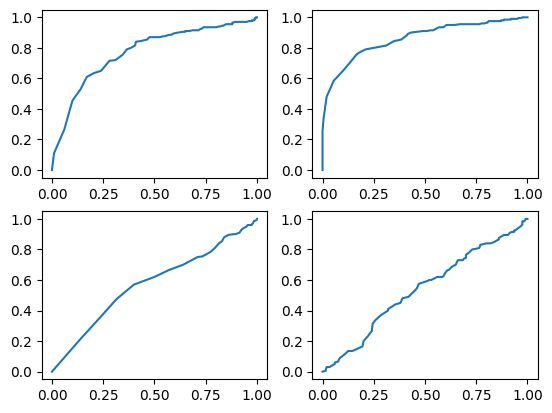

In [ ]:
# All 3 Channels
fig, ax = plt.subplots(2,2)
ax[0,0].plot(fpr_p_pn, tpr_p_pn)
ax[0,1].plot(fpr_s_pn, tpr_s_pn)
ax[1,0].plot(fpr_p_eqt, tpr_p_eqt)
ax[1,1].plot(fpr_s_eqt, tpr_s_eqt)

NameError: name 'fpr_p_pn' is not defined

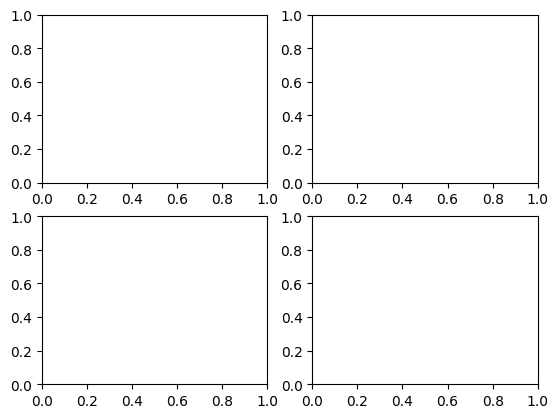

In [12]:
# Only Z Channel
fig, ax = plt.subplots(2,2)
ax[0,0].plot(fpr_p_pn, tpr_p_pn)
ax[0,1].plot(fpr_s_pn, tpr_s_pn)
ax[1,0].plot(fpr_p_eqt, tpr_p_eqt)
ax[1,1].plot(fpr_s_eqt, tpr_s_eqt)

## Signal To Noise Precision & Recall Plots

In [97]:
prec, recall = precision_recall(preds_eqt_maxs_eq[0], preds_eqt_maxs_noise[0], theta = 0.5)
prec, recall

(tensor(0.4987), tensor(0.9950))

total events in csv file: 200000
total events selected: 200000


/var/folders/jp/cc_r_y3x6clgl7b4rwk3lgfw0000gn/T/ipykernel_66615/730885282.py:7: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)


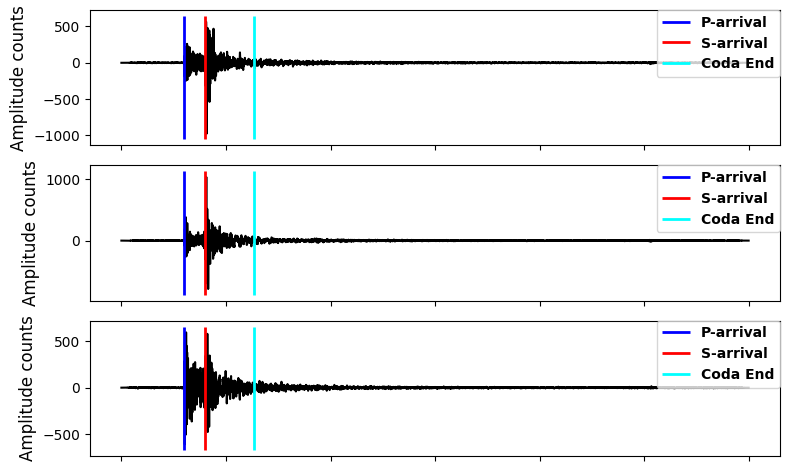

back_azimuth_deg 92.5
coda_end_sample [[1271.]]
network_code PB
p_arrival_sample 599.0
p_status autopicker
p_travel_sec 2.7799999713897705
p_weight 0.94
receiver_code B087
receiver_elevation_m 1139.0
receiver_latitude 33.4955
receiver_longitude -116.602667
receiver_type EH
s_arrival_sample 801.0
s_status autopicker
s_weight 0.84
snr_db [39.29999924 35.90000153 35.5       ]
source_depth_km 10.3
source_depth_uncertainty_km 0.68
source_distance_deg 0.09954
source_distance_km 11.07
source_error_sec 0.22
source_gap_deg 97.0
source_horizontal_uncertainty_km 0.36
source_id ci15072004
source_latitude 33.4911667
source_longitude -116.4836667
source_magnitude 1.22
source_magnitude_author CI
source_magnitude_type ml
source_mechanism_strike_dip_rake None
source_origin_time 2011-11-03 06:28:09.000000
source_origin_uncertainty_sec nan
trace_category earthquake_local
trace_name B087.PB_20111103062804_EV
trace_start_time 2011-11-03 06:28:05.790000


TypeError: 'numpy.ndarray' object is not callable

In [110]:
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt

# reading the csv file into a dataframe:
df = pd.read_csv(csv_file)
print(f'total events in csv file: {len(df)}')
# filterering the dataframe
#df = df[(df.trace_category == 'earthquake_local') & (df.source_distance_km <= 20) & (df.source_magnitude > 3)]
print(f'total events selected: {len(df)}')

# making a list of trace names for the selected data
ev_list = df['trace_name'].to_list()

# retrieving selected waveforms from the hdf5 file: 
dtfl = h5py.File(file_name, 'r')
for c, evi in enumerate(ev_list):
    dataset = dtfl.get('data/'+str(evi)) 
    # waveforms, 3 channels: first row: E channel, second row: N channel, third row: Z channel 
    data = np.array(dataset)

    fig = plt.figure()
    ax = fig.add_subplot(311)         
    plt.plot(data[:,0], 'k')
    plt.rcParams["figure.figsize"] = (8, 5)
    legend_properties = {'weight':'bold'}    
    plt.tight_layout()
    ymin, ymax = ax.get_ylim()
    pl = plt.vlines(dataset.attrs['p_arrival_sample'], ymin, ymax, color='b', linewidth=2, label='P-arrival')
    sl = plt.vlines(dataset.attrs['s_arrival_sample'], ymin, ymax, color='r', linewidth=2, label='S-arrival')
    cl = plt.vlines(dataset.attrs['coda_end_sample'], ymin, ymax, color='aqua', linewidth=2, label='Coda End')
    plt.legend(handles=[pl, sl, cl], loc = 'upper right', borderaxespad=0., prop=legend_properties)        
    plt.ylabel('Amplitude counts', fontsize=12) 
    ax.set_xticklabels([])

    ax = fig.add_subplot(312)         
    plt.plot(data[:,1], 'k')
    plt.rcParams["figure.figsize"] = (8, 5)
    legend_properties = {'weight':'bold'}    
    plt.tight_layout()
    ymin, ymax = ax.get_ylim()
    pl = plt.vlines(dataset.attrs['p_arrival_sample'], ymin, ymax, color='b', linewidth=2, label='P-arrival')
    sl = plt.vlines(dataset.attrs['s_arrival_sample'], ymin, ymax, color='r', linewidth=2, label='S-arrival')
    cl = plt.vlines(dataset.attrs['coda_end_sample'], ymin, ymax, color='aqua', linewidth=2, label='Coda End')
    plt.legend(handles=[pl, sl, cl], loc = 'upper right', borderaxespad=0., prop=legend_properties)        
    plt.ylabel('Amplitude counts', fontsize=12) 
    ax.set_xticklabels([])

    ax = fig.add_subplot(313)         
    plt.plot(data[:,2], 'k')
    plt.rcParams["figure.figsize"] = (8,5)
    legend_properties = {'weight':'bold'}    
    plt.tight_layout()
    ymin, ymax = ax.get_ylim()
    pl = plt.vlines(dataset.attrs['p_arrival_sample'], ymin, ymax, color='b', linewidth=2, label='P-arrival')
    sl = plt.vlines(dataset.attrs['s_arrival_sample'], ymin, ymax, color='r', linewidth=2, label='S-arrival')
    cl = plt.vlines(dataset.attrs['coda_end_sample'], ymin, ymax, color='aqua', linewidth=2, label='Coda End')
    plt.legend(handles=[pl, sl, cl], loc = 'upper right', borderaxespad=0., prop=legend_properties)        
    plt.ylabel('Amplitude counts', fontsize=12) 
    ax.set_xticklabels([])
    plt.show() 

    for at in dataset.attrs:
        print(at, dataset.attrs[at])    

    inp = input("Press a key to plot the next waveform!")
    if inp == "r":
        continue             

# Bayesian Phase Picker

In [118]:
import torch

class ArmstrongPicker(torch.nn.Module):

    def __init__(self, num_channels=1, min_lag=-0.5, max_lag=0.5):
        super(ModifiedArmstrongPicker, self).__init__()
        from torch.nn import MaxPool1d, Conv1d, Linear
        self.relu = torch.nn.ReLU()
        self.min_lag = min_lag
        self.max_lag = max_lag
        self.Hardtanh = torch.nn.Hardtanh(min_val=self.min_lag, max_val=self.max_lag)
        filter1 = 21
        filter2 = 15
        filter3 = 11

        # Calculating the output shape after the convolutional and pooling layers
        linear_shape = 128 * 750  # channels * length

        self.maxpool = MaxPool1d(kernel_size=2, stride=2)
        self.conv1 = Conv1d(num_channels, 32, kernel_size=filter1, padding=filter1 // 2)
        self.bn1 = torch.nn.BatchNorm1d(32, eps=1e-05, momentum=0.1)
        
        self.conv2 = Conv1d(32, 64, kernel_size=filter2, padding=filter2 // 2)
        self.bn2 = torch.nn.BatchNorm1d(64, eps=1e-05, momentum=0.1)

        self.conv3 = Conv1d(64, 128, kernel_size=filter3, padding=filter3 // 2)
        self.bn3 = torch.nn.BatchNorm1d(128, eps=1e-05, momentum=0.1)

        self.fcn1 = Linear(linear_shape, 512)
        self.bn4 = torch.nn.BatchNorm1d(512, eps=1e-05, momentum=0.1)
  
        self.fcn2 = Linear(512, 512)
        self.bn5 = torch.nn.BatchNorm1d(512, eps=1e-05, momentum=0.1)

        self.fcn3 = Linear(512, 1)

    def forward(self, x):
        # First convolutional layer
        x = self.conv1(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.maxpool(x)
        
        # Second convolutional layer
        x = self.conv2(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = self.maxpool(x)
        
        # Third convolutional layer
        x = self.conv3(x)
        x = self.relu(x)
        x = self.bn3(x)
        x = self.maxpool(x)
        
        # Flatten
        x = x.flatten(1)
        
        # First fully connected layer
        x = self.fcn1(x)
        x = self.relu(x)
        x = self.bn4(x)
        
        # Second fully connected layer
        x = self.fcn2(x)
        x = self.relu(x)
        x = self.bn5(x)
        
        # Last layer
        x = self.fcn3(x)
        
        # Force linear layer to be between +/- 0.5
        x = self.Hardtanh(x)
        return x

class SimplifiedArmstrongPicker(torch.nn.Module):

    def __init__(self, num_channels=1, input_length=1500, min_lag=-0.5, max_lag=0.5):
        super(SimplifiedArmstrongPicker, self).__init__()
        from torch.nn import MaxPool1d, Conv1d, Linear
        self.relu = torch.nn.ReLU()
        self.min_lag = min_lag
        self.max_lag = max_lag
        self.Hardtanh = torch.nn.Hardtanh(min_val=self.min_lag, max_val=self.max_lag)
        
        filter1 = 11
        filter2 = 7

        # Calculating the output shape after the convolutional and pooling layers
        linear_shape = 64 * 1500  # channels * length after 2 maxpools

        self.maxpool = MaxPool1d(kernel_size=2, stride=2)
        self.conv1 = Conv1d(num_channels, 16, kernel_size=filter1, padding=filter1 // 2)
        self.bn1 = torch.nn.BatchNorm1d(16, eps=1e-05, momentum=0.1)
        
        self.conv2 = Conv1d(16, 64, kernel_size=filter2, padding=filter2 // 2)
        self.bn2 = torch.nn.BatchNorm1d(64, eps=1e-05, momentum=0.1)

        self.fcn1 = Linear(linear_shape, 256)
        self.bn3 = torch.nn.BatchNorm1d(256, eps=1e-05, momentum=0.1)
  
        self.fcn2 = Linear(256, 1)

    def forward(self, x):
        # First convolutional layer
        x = self.conv1(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.maxpool(x)
        
        # Second convolutional layer
        x = self.conv2(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = self.maxpool(x)
        
        # Flatten
        x = x.flatten(1)
        
        # First fully connected layer
        x = self.fcn1(x)
        x = self.relu(x)
        x = self.bn3(x)
        
        # Last layer
        x = self.fcn2(x)
        
        # Force linear layer to be between +/- 0.5
        x = self.Hardtanh(x)
        return x

# Create a test model and a random tensor with shape [1000, 3, 6000]
#model = ModifiedArmstrongPicker()
#test_input = torch.randn(1000, 1, 6000)
#output = model(wave_tensor_eq[:,2:3,:])
#output.shape

class WaveDataset(Dataset):
    def __init__(self, wave_tensor, labels):
        self.wave_tensor = wave_tensor
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.wave_tensor[idx, 2:3, :], self.labels[idx,2:3]

# Create the dataset and dataloader
wave_dataset = WaveDataset(wave_tensor_eq, labels_eq)
wave_dataloader = DataLoader(wave_dataset, batch_size=128, shuffle=True)

In [111]:
model = SimplifiedArmstrongPicker()

# Number of training epochs
epochs_new = 20

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
training_losses = []

for epoch in range(epochs_new):
    model.train()
    total_loss = 0.0

    for batch_idx, (data, target) in enumerate(wave_dataloader):
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output.squeeze(), target.float())
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    avg_loss = total_loss/len(wave_dataloader)
    training_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs_new}, Loss: {avg_loss}")

training_losses

/Users/noahliniger/opt/miniconda3/envs/dslab/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/noahliniger/opt/miniconda3/envs/dslab/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([104, 1])) that is different to the input size (torch.Size([104])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/20, Loss: 6367318.875
Epoch 2/20, Loss: 6360255.125
Epoch 3/20, Loss: 6365543.375
Epoch 4/20, Loss: 6384778.8125
Epoch 5/20, Loss: 6370499.1875
Epoch 6/20, Loss: 6361945.1875
Epoch 7/20, Loss: 6370071.125
Epoch 8/20, Loss: 6359861.25
Epoch 9/20, Loss: 6360105.25
Epoch 10/20, Loss: 6355605.75
Epoch 11/20, Loss: 6347784.5
Epoch 12/20, Loss: 6367923.625
Epoch 13/20, Loss: 6351963.875
Epoch 14/20, Loss: 6380714.4375
Epoch 15/20, Loss: 6354375.4375
Epoch 16/20, Loss: 6366342.375
Epoch 17/20, Loss: 6346622.375
Epoch 18/20, Loss: 6365792.25
Epoch 19/20, Loss: 6335154.5625
Epoch 20/20, Loss: 6377619.8125


[6367318.875,
 6360255.125,
 6365543.375,
 6384778.8125,
 6370499.1875,
 6361945.1875,
 6370071.125,
 6359861.25,
 6360105.25,
 6355605.75,
 6347784.5,
 6367923.625,
 6351963.875,
 6380714.4375,
 6354375.4375,
 6366342.375,
 6346622.375,
 6365792.25,
 6335154.5625,
 6377619.8125]

In [ ]:
la = Laplace(model, 'regression', subset_of_weights='all', hessian_structure='full')
la.fit(wave_dataloader)
log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
n_epochs = 10000
for i in range(n_epochs):
    hyper_optimizer.zero_grad()
    neg_marglik = - la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()